# Library Imports

We import all the necessary Python libraries used throughout the analysis.

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import jaccard_score
from itertools import combinations
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
import string

from transformers import BertTokenizerFast
from collections import Counter

!pip install datasets
import datasets

# Dataset Loading

We load the dataset containing research papers and select the relevant columns for our analysis.
We perform a quick inspection of the dataset to understand its structure and contents.

In [2]:
# Load the dataset from local CSV file
df = pd.read_csv('../Datasets/cs_papers_api.csv')

In [3]:
print(df.shape)
df.columns

(200094, 6)


Index(['paper_id', 'title', 'abstract', 'year', 'primary_category',
       'categories'],
      dtype='object')

# Explorative analysis

## Distribution paper per year


To better understand the temporal distribution of the dataset, we extract the publication year from the original date field and create a bar plot.


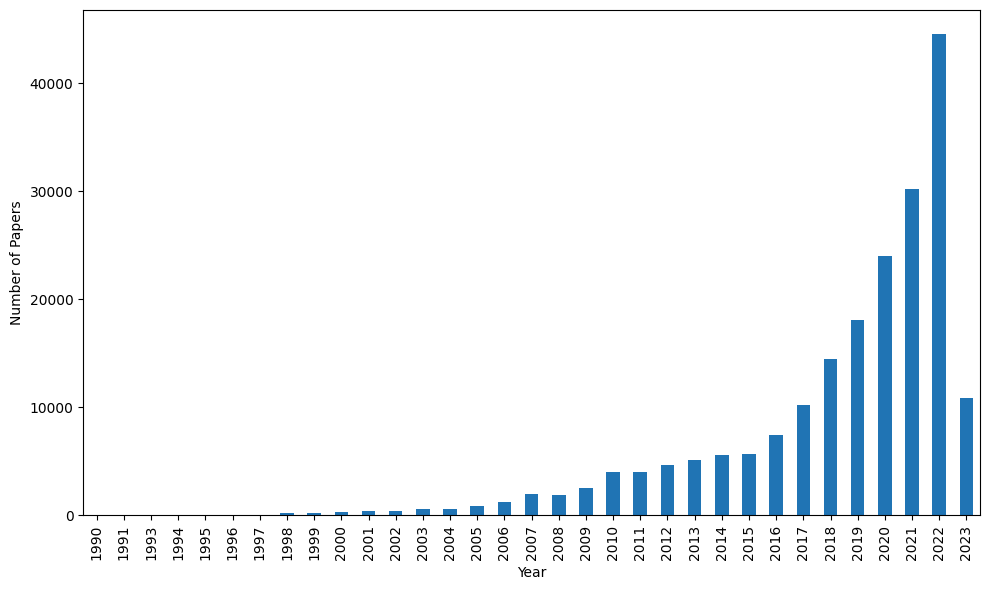

In [4]:
df['year_'] = pd.to_datetime(df['year']).dt.year

year_counts = df['year_'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
year_counts.plot(kind='bar', color= "#2074b4")
#plt.title('Number of Papers Published per Year')
plt.xlabel('Year')
plt.ylabel('Number of Papers')
plt.tight_layout()

plt.savefig('../Plots/papers_per_year.png', dpi=300)
plt.show()

Analyzing the plot, we observe that the number of published papers follows an approximately exponential growth trend. Specifically:

- The total number of publications increases steadily year by year.
- Starting from 2017, there is a notable surge in research output within this field, with the annual number of papers rising from fewer than 10000 to over 40000 publications.

This rapid growth reflects the increasing scientific interest and advancements in the domain over recent years.


## Distribuzion of categories (classes)

We analyze the number of unique categories present in the dataset and visualize their frequency distribution.


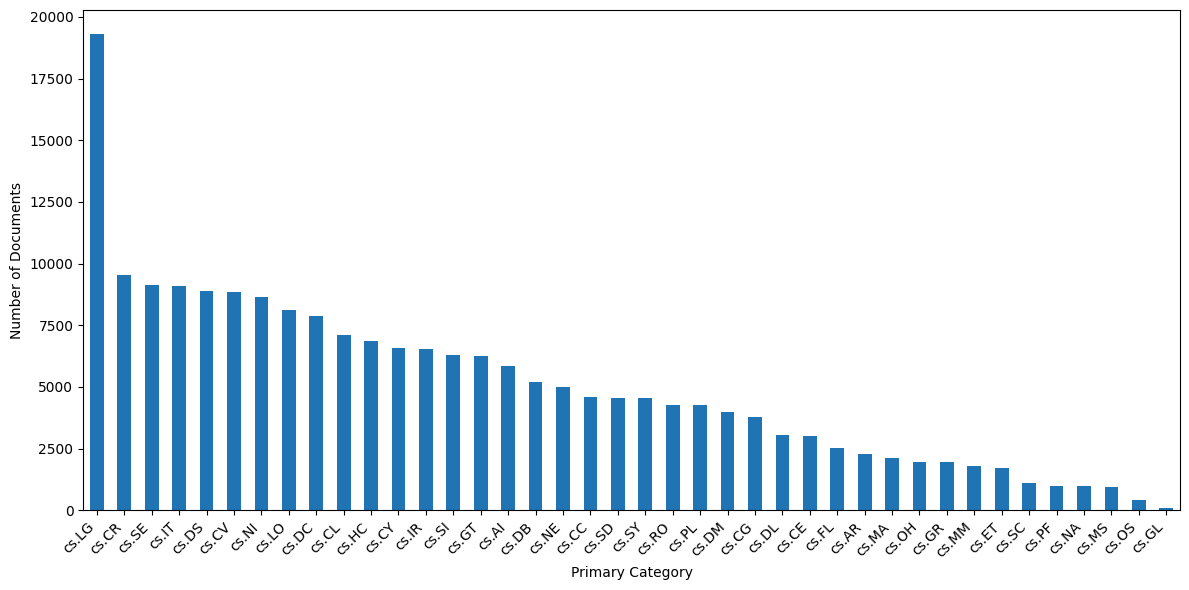

Number of unique primary categories: 40


In [5]:
# Plot the frequency of each category
df['primary_category'].value_counts().plot(kind='bar', figsize=(12,6), color = "#2074b4")

# Plot formatting
#plt.title('Distribution of Documents by Primary Category')
plt.xlabel('Primary Category')
plt.ylabel('Number of Documents')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("../Plots/Classes_abstract.png", dpi = 300)
plt.show()

# Count the number of unique primary categories
num_unique_categories = df['primary_category'].nunique()
print(f"Number of unique primary categories: {num_unique_categories}")

We have 40 distinct classes in our dataset. This information is important because the final layers of our model must be adapted to handle classification across these 40 categories. Additionally, the classes are highly imbalanced. Therefore, it is necessary to consider techniques to address this imbalance. There are several possible approaches to mitigate the effects of class imbalance, which will be explored in the following scripts

## Length abstract


We preprocess the abstracts by explicitly separating punctuation from words using spaces. This allows us to treat punctuation marks as individual tokens, which can be important for certain text analysis tasks.

- The function `separate_tokens` inserts spaces around all punctuation characters.
- Multiple consecutive spaces are reduced to a single space.
- After preprocessing, we calculate the length of each abstract in terms of tokens, where punctuation counts as separate tokens.

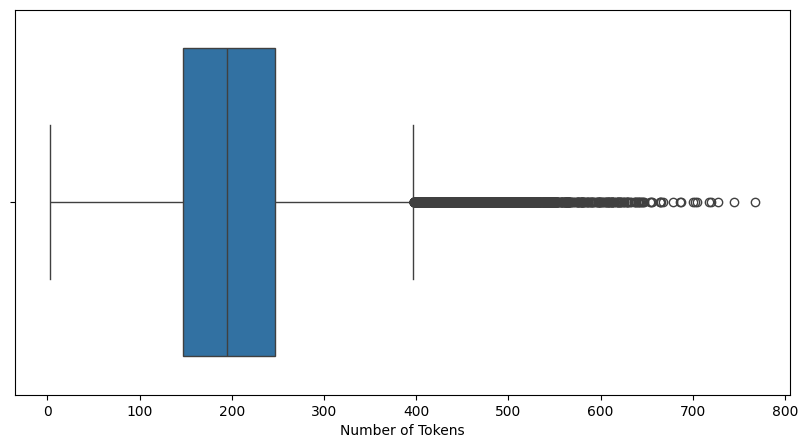

count    200094.000000
mean        200.287455
std          76.802531
min           3.000000
25%         147.000000
50%         195.000000
75%         247.000000
max         767.000000
Name: abstract, dtype: float64


In [6]:
def separate_tokens(text):
    # Insert spaces around punctuation characters
    text = re.sub(r'([^\w\s])', r' \1 ', str(text))
    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

# Apply token separation on the 'abstract' column
abstract_preprocessed = df['abstract'].apply(separate_tokens)

# Calculate number of tokens per abstract 
abstract_length = abstract_preprocessed.apply(lambda x: len(x.split()))


# Plot boxplot of abstract lengths
plt.figure(figsize=(10, 5))
sns.boxplot(x=abstract_length, color= "#2074b4")
#plt.title('Boxplot of Abstract Lengths (Words + Separated Punctuation)')
plt.xlabel('Number of Tokens')

plt.savefig('../Plots/length_abstract.png', dpi=300)
plt.show()


# Display summary statistics
print(abstract_length.describe())

By applying BERT's requirement that input sequences must not exceed 512 tokens, we observe that this constraint needs to be carefully managed. A possible strategy involves segmenting longer abstracts into smaller chunks of up to 512 tokens, and then aggregating the model outputs to avoid losing important information from the original text.

## Most influential words 
We analyze the TF-IDF scores across all abstracts to identify the most influential terms in the entire dataset.

After computing the TF-IDF matrix, we sum the TF-IDF weights of each term across all abstracts. 

This gives us a measure of how important each term is, not just within individual abstract. 

Finally, visualize the top 30 terms with the highest global TF-IDF scores using a bar chart.

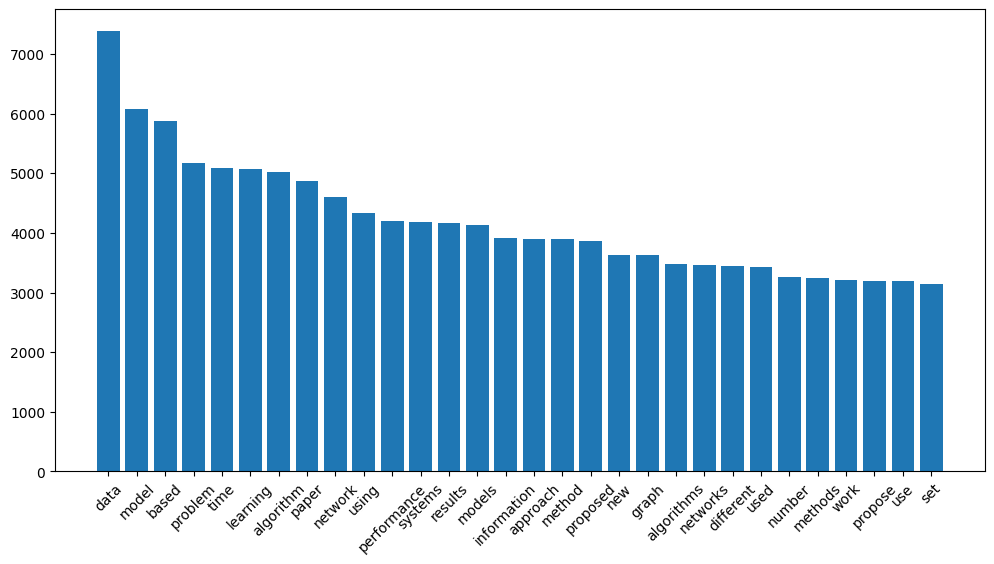

In [7]:
# Apply TF-IDF vectorization 

vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(abstract_preprocessed)

# Get the list of vocabulary terms used by the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Sum of TF-IDF weights across all abstracts
tfidf_sums = tfidf_matrix.sum(axis=0)  # shape: (1, num_terms)

# Convert in a flat array
tfidf_sums = np.asarray(tfidf_sums).flatten()

# Sort and take the top 30 words
top_indices = tfidf_sums.argsort()[-30:][::-1]
top_words = [feature_names[i] for i in top_indices]

# See the plot

plt.figure(figsize=(12, 6))
plt.bar(top_words, tfidf_sums[top_indices])
plt.xticks(rotation=45)
#plt.title("Top 30 words to TF-IDF")

plt.savefig("../Plots/30_most_influent_words.png", dpi=300)
plt.show()

### Top TF-IDF Terms for each category

To better understand how similar or distinct the macrotopic are, we compute the top 40 most representative TF-IDF terms for each primary category in the dataset.

- For each category, we compute the mean TF-IDF vector over all abstracts belonging to it.
- We then extract the top 40 words with the highest average TF-IDF scores for each category.
- These words represent the most distinctive terms within each research domain.

To evaluate the amount of overlap among categories we compute the **Jaccard similarity** between the top-words sets of each pair of categories.

This analysis is useful to evaluate whether classification based on text is feasible and whether some classes should potentially be merged or carefully managed during training.

In [8]:
# Dictionary to store top TF-IDF words per category
category_top_words = {}

# Iterate through each unique category
for cat in df['primary_category'].unique():
    # Select abstracts that belong to this category
    subset = df[df['primary_category'] == cat]
    
    # Extract TF-IDF submatrix for the current subset
    subset_tfidf = tfidf_matrix[subset.index]
    
    # Compute the mean TF-IDF score for each word in the subset
    mean_tfidf = np.asarray(subset_tfidf.mean(axis=0)).flatten()
    
    # Identify indices of the top 40 highest-scoring words
    top_indices = mean_tfidf.argsort()[-40:][::-1]
    
    # Map indices to actual terms
    top_words = [feature_names[i] for i in top_indices]
    
    # Store in dictionary
    category_top_words[cat] = top_words


In [9]:
# Create sets of words per category for Jaccard similarity
category_word_sets = {cat: set(words) for cat, words in category_top_words.items()}

# Compute Jaccard similarity between all pairs of categories
similarity_results = []
for cat1, cat2 in combinations(category_word_sets.keys(), 2):
    set1, set2 = category_word_sets[cat1], category_word_sets[cat2]
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    jaccard = intersection / union if union != 0 else 0
    similarity_results.append((cat1, cat2, jaccard))

# Sort results in descending order to find most similar category pairs
similarity_results.sort(key=lambda x: -x[2])

# Display top 10 most similar category pairs
print("Most similar category pairs based on Jaccard index:")
for cat1, cat2, sim in similarity_results[:10]:
    print(f"{cat1} vs {cat2} → Jaccard: {sim:.2f}")

Most similar category pairs based on Jaccard index:
cs.NE vs cs.LG → Jaccard: 0.51
cs.CV vs cs.SD → Jaccard: 0.48
cs.DS vs cs.CG → Jaccard: 0.48
cs.CC vs cs.DM → Jaccard: 0.45
cs.CL vs cs.SD → Jaccard: 0.43
cs.ET vs cs.AR → Jaccard: 0.43
cs.CC vs cs.DS → Jaccard: 0.43
cs.DS vs cs.DM → Jaccard: 0.43
cs.CV vs cs.CL → Jaccard: 0.40
cs.CG vs cs.DM → Jaccard: 0.40


We observe that only three category pairs share approximately 50% of their most distinctive words. This indicates that, overall, the categories are relatively well-separated in terms of vocabulary. As a result, it is reasonable to proceed with all 40 classes in our classification task using BERT. The performance of the model will help further validate whether this level of lexical separation is sufficient for accurate classification.

### Vocabulary Comparison Between Dataset and BERT Tokenizer

We extract the most frequent words from scientific abstracts and compare this vocabulary with the set of token of BERT's tokenizer (using a Wikipedia subset as representative corpus). The overlap ratio quantifies how many of our domain-specific words are covered by BERT's vocabulary.

A high overlap suggests that BERT's base tokenizer sufficiently covers the terminology in the dataset, making it a strong candidate for direct fine-tuning. Conversely, a low overlap may indicate the need for domain-adapted models like SciBERT or additional tokenizer training.


In [10]:
"""#  Build custom vocabulary from abstracts


# Define English stopwords and punctuation
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)

# Initialize a counter for word frequencies
word_counts = Counter()

for text in df["abstract"]:
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = ''.join(ch for ch in text if ch not in punctuation)
    # Tokenize by splitting on whitespace
    words = text.split()
    # Remove stopwords
    words = [w for w in words if w not in stop_words]
    # Update frequency counts
    word_counts.update(words)

# Extract the vocabulary ordered by frequency
custom_vocab = [word for word, count in word_counts.most_common()]
print(f"Custom vocabulary size: {len(custom_vocab)}")

# Show top 20 most frequent words in abstracts
print("Top 20 words from abstracts:", custom_vocab[:20])
"""

Custom vocabulary size: 361310
Top 20 words from abstracts: ['data', 'model', 'paper', 'problem', 'learning', 'show', 'results', 'using', 'algorithm', 'based', 'network', 'performance', 'also', 'system', 'models', 'time', 'proposed', 'systems', 'approach', 'information']


In [12]:
"""# Load BERT tokenizer and build BERT vocabulary from tokenized Wikipedia subset

# Initialize BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

# Load small subset of Wikipedia dataset for representative BERT vocabulary tokens
dataset = datasets.load_dataset("wikimedia/wikipedia", "20231101.en", split="train[:0.1%]")

bert_token_counts = Counter()

# Tokenize and count tokens in dataset
for article in dataset:
    tokens = tokenizer.tokenize(article["text"])
    bert_token_counts.update(tokens)

# Get BERT vocabulary tokens sorted by frequency
bert_vocab = [token for token, count in bert_token_counts.most_common()]
print(f"BERT tokenizer vocabulary size (top tokens from Wikipedia subset): {len(bert_vocab)}")

# Show top 20 most frequent BERT tokens
print("Top 20 BERT tokens:", bert_vocab[:20])
"""

Resolving data files:   0%|          | 0/41 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/6407814 [00:00<?, ? examples/s]

DatasetGenerationError: An error occurred while generating the dataset

In [ ]:
"""#  Compute the overlap between custom vocab and BERT vocab

# Convert vocab lists to sets
custom_vocab_set = set(custom_vocab)
bert_vocab_set = set(bert_vocab)

# Compute intersection and union
common_tokens = custom_vocab_set & bert_vocab_set
union_tokens = custom_vocab_set | bert_vocab_set

# Compute Jaccard similarity (overlap ratio)
overlap_ratio = len(common_tokens) / len(custom_vocab_set)

print(f"Number of common tokens: {len(common_tokens)}")
print(f"Vocabulary overlap ratio (custom_vocab vs BERT vocab): {overlap_ratio:.2%}")
"""

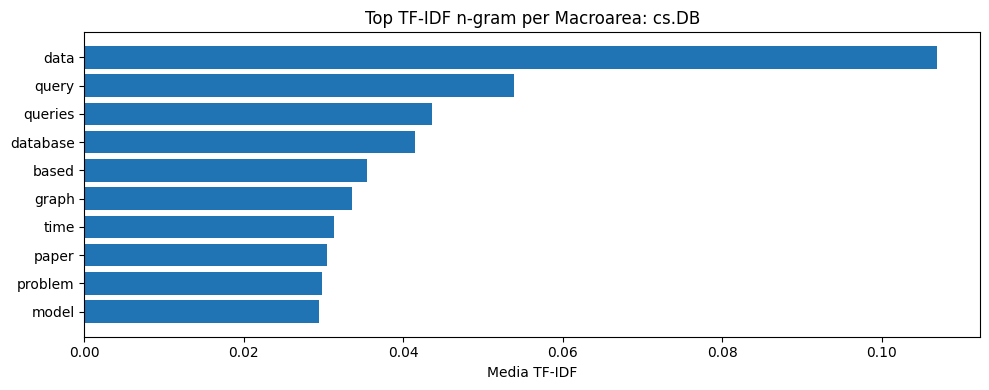

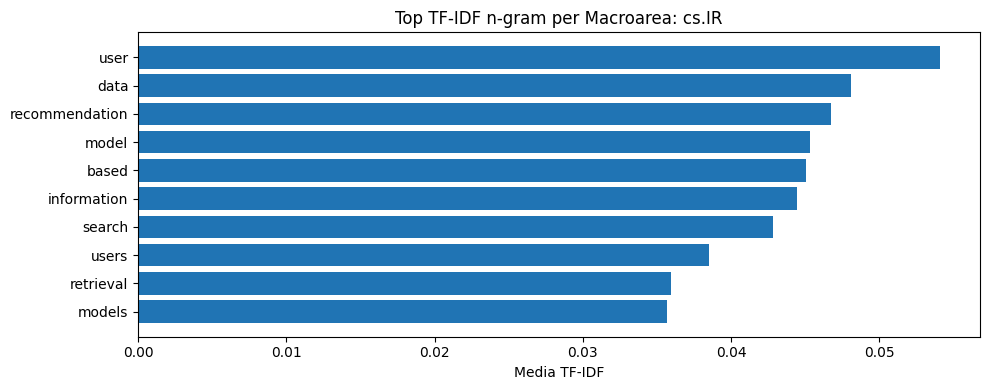

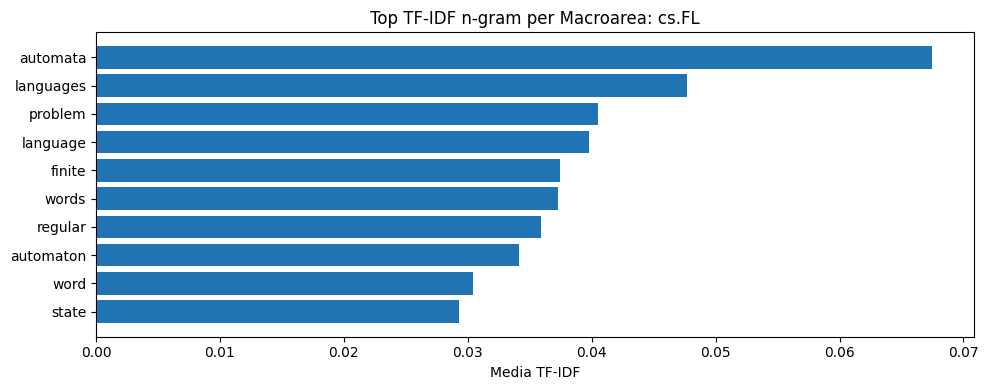

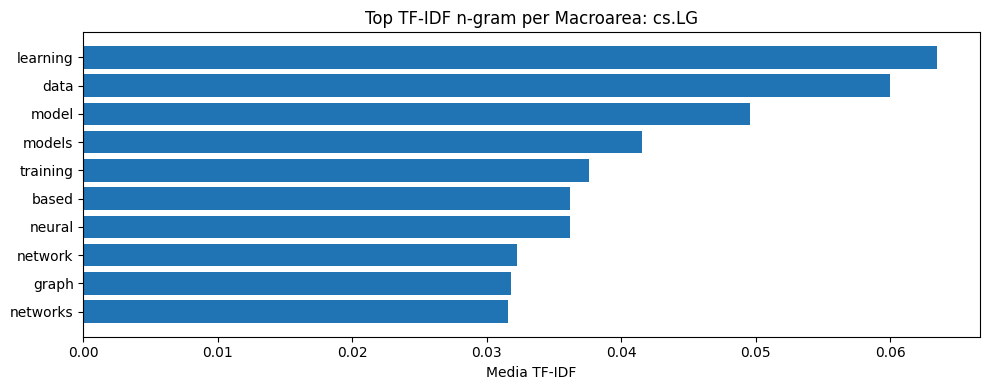

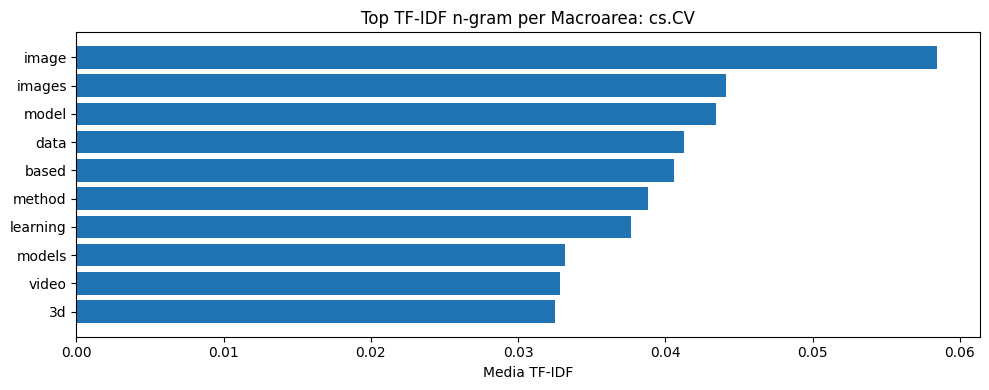

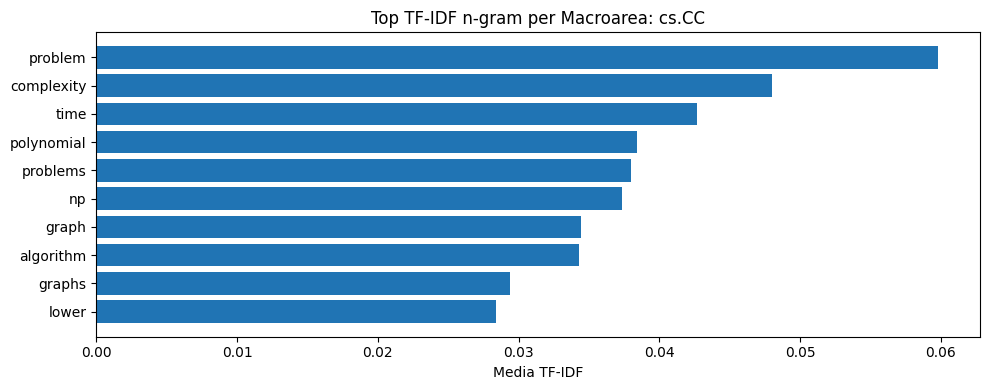

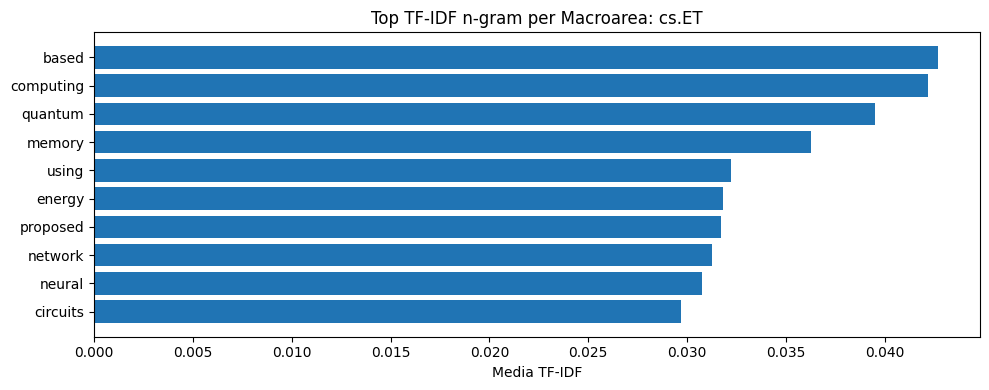

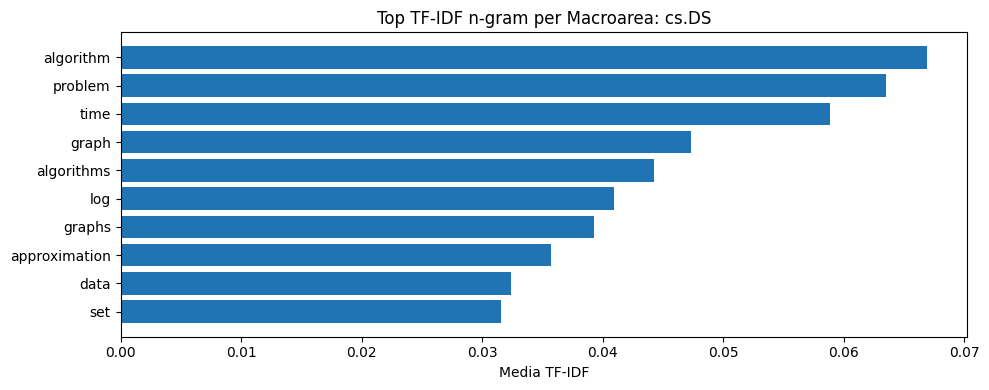

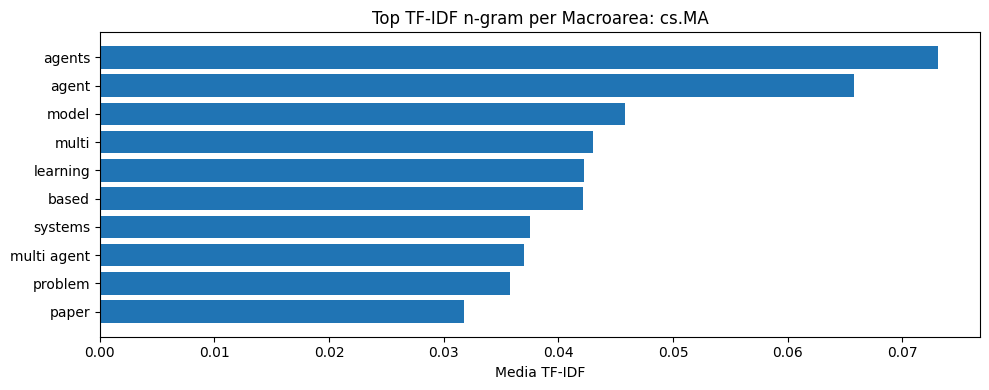

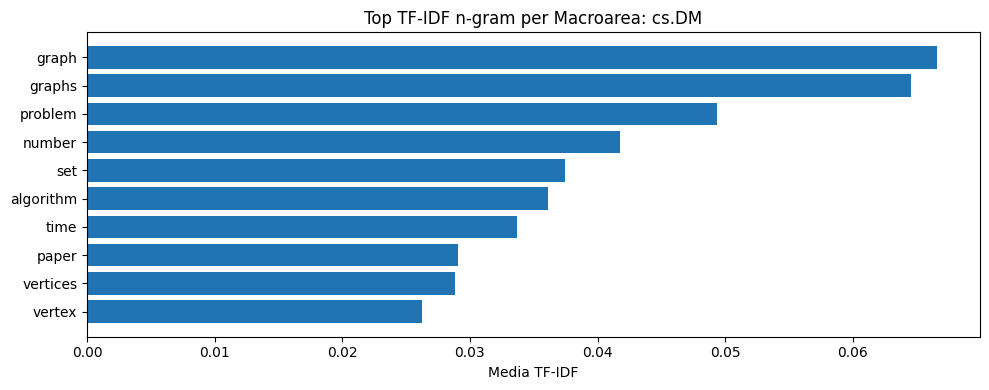

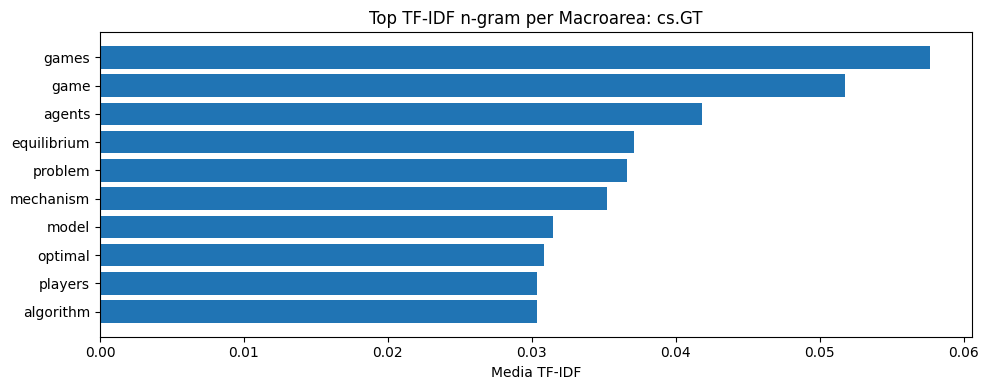

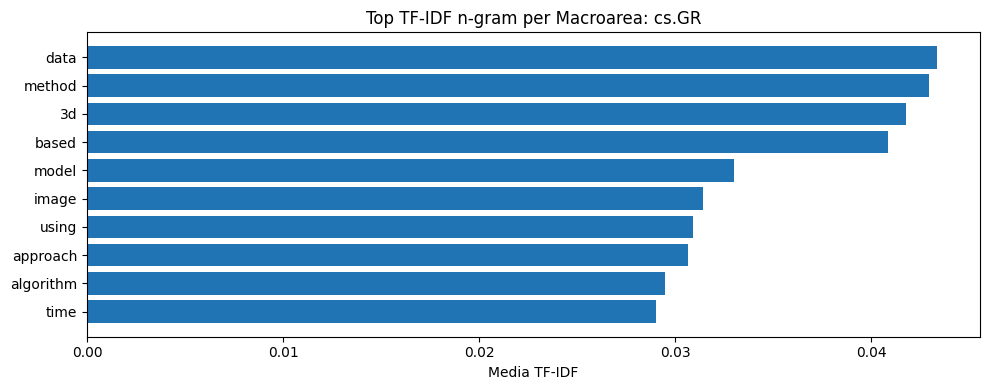

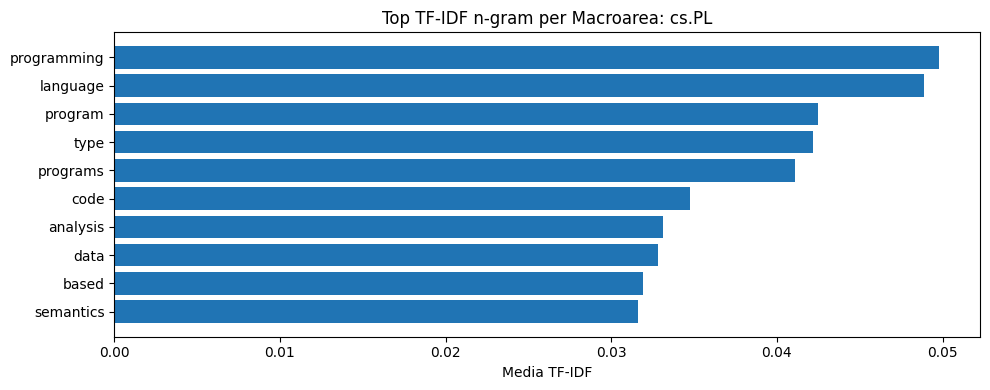

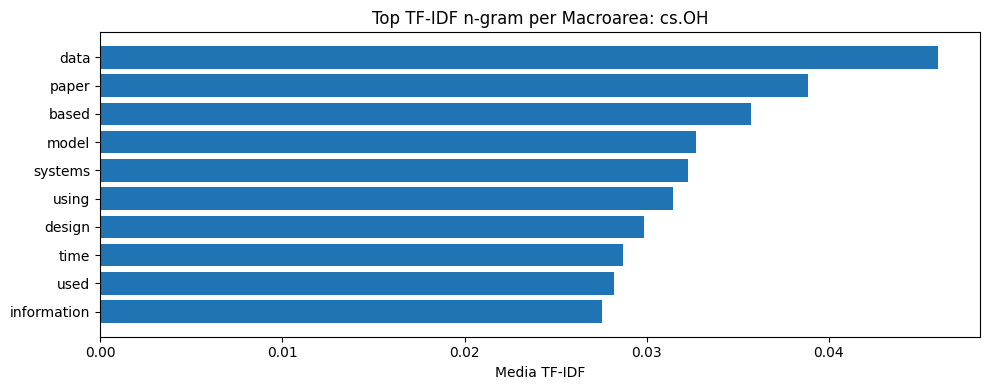

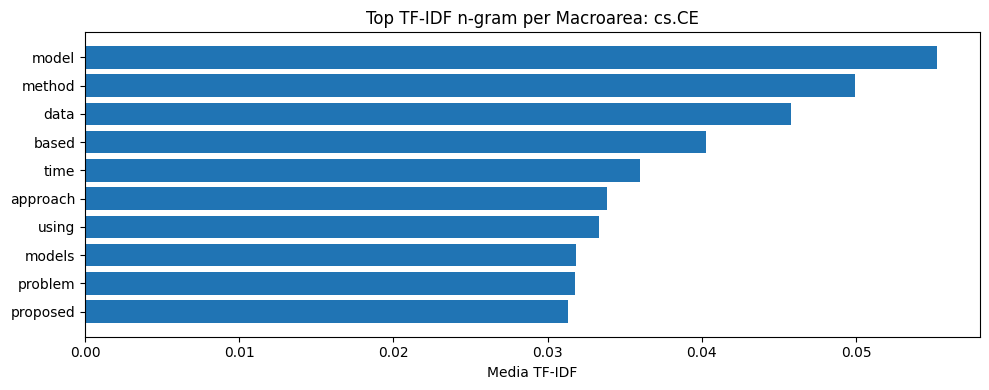

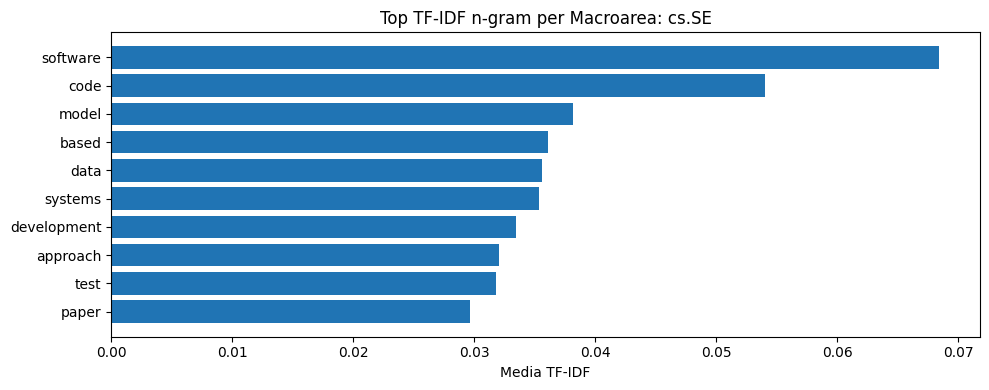

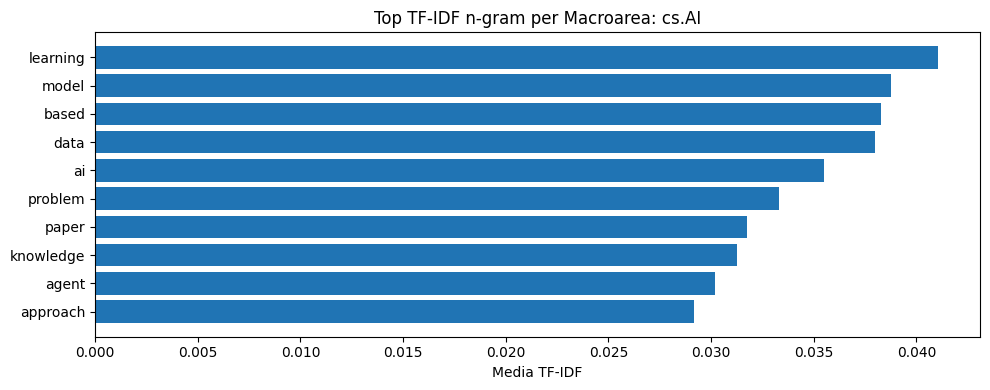

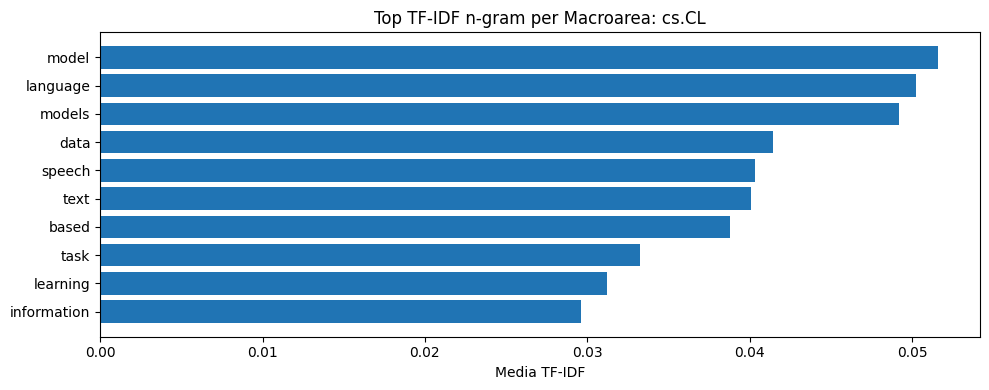

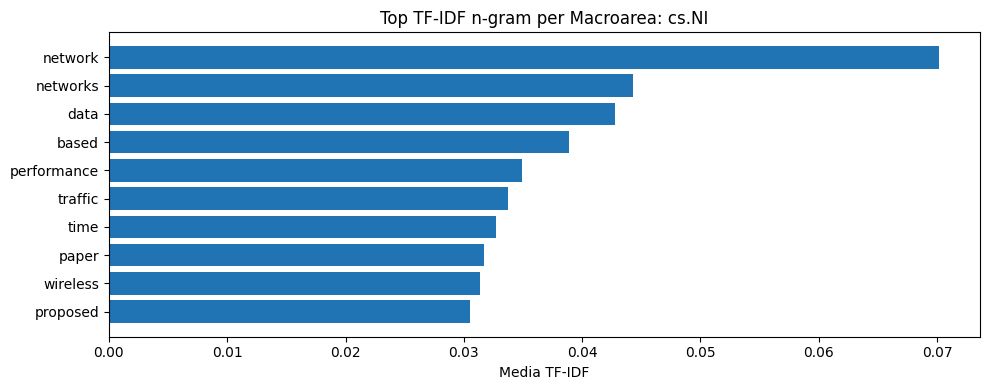

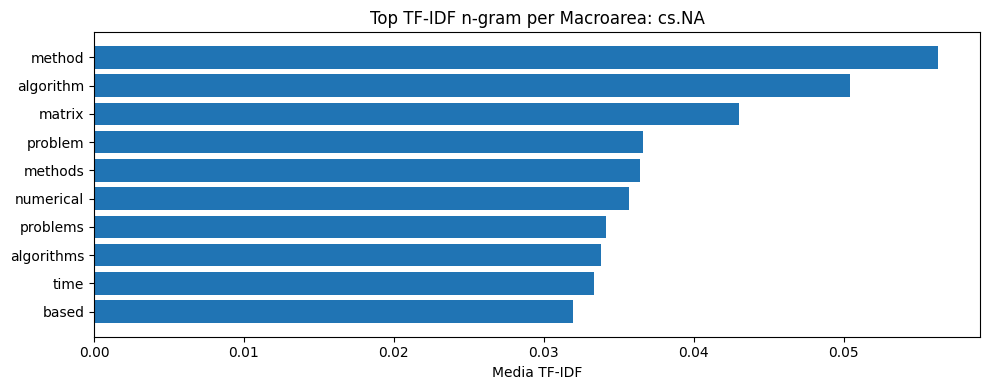

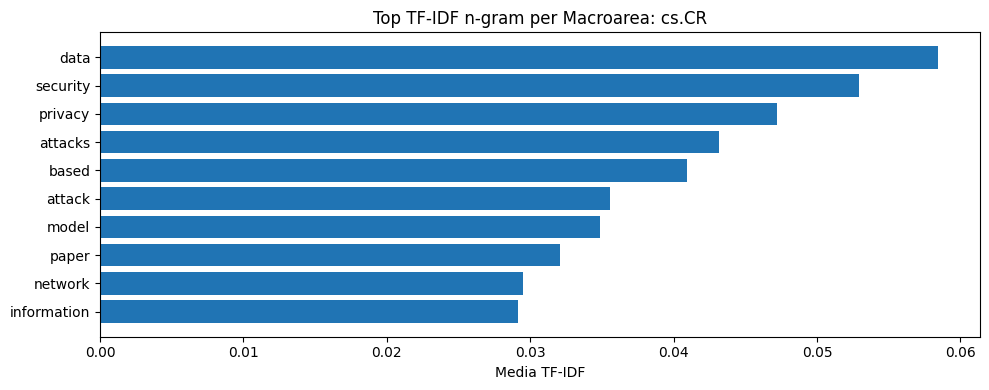

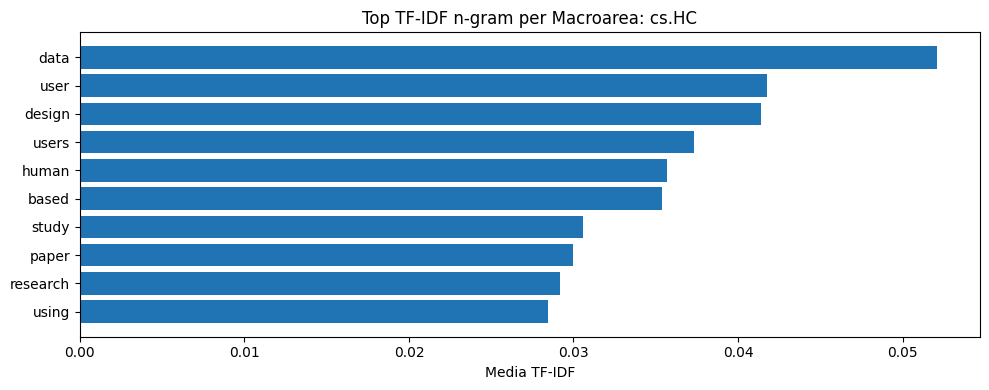

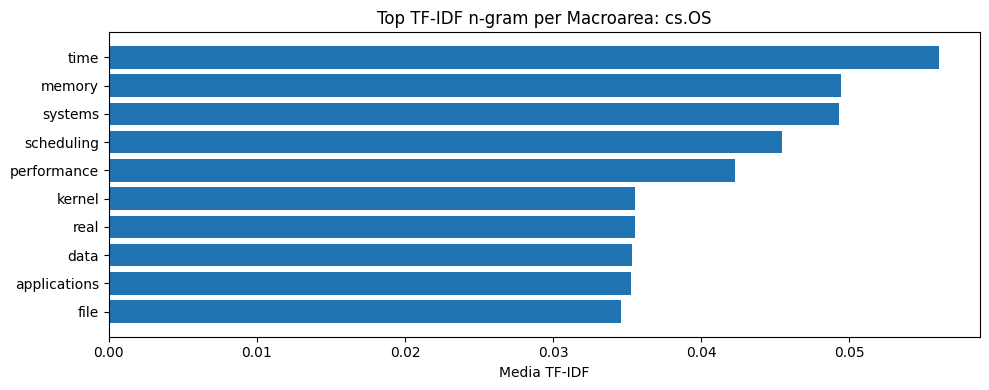

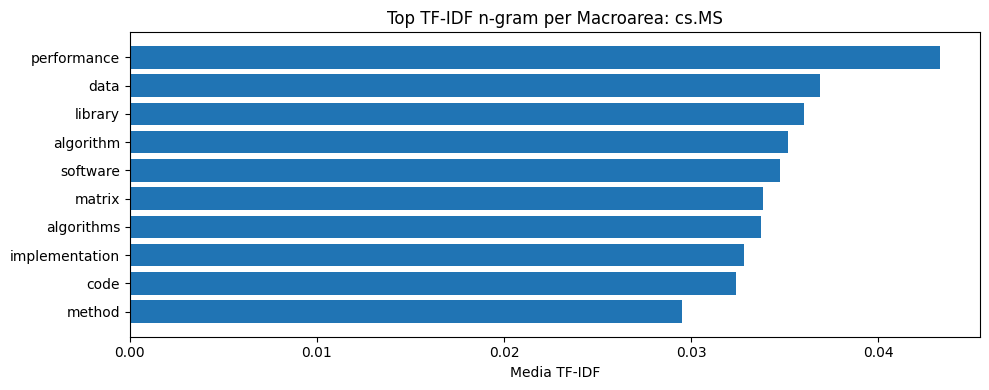

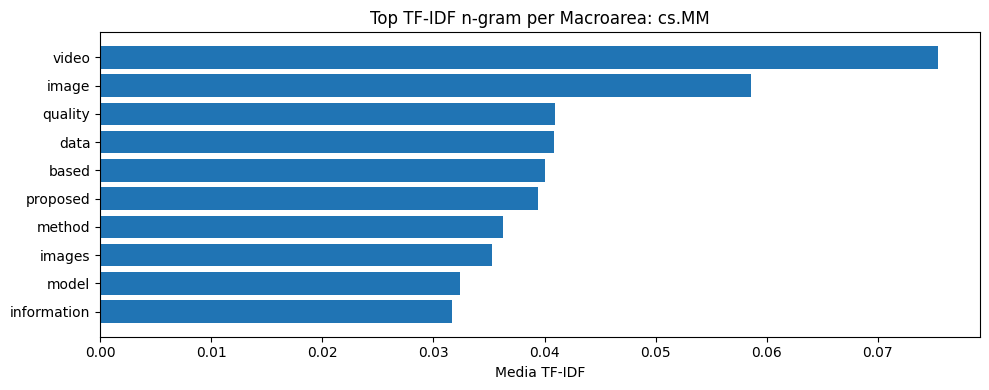

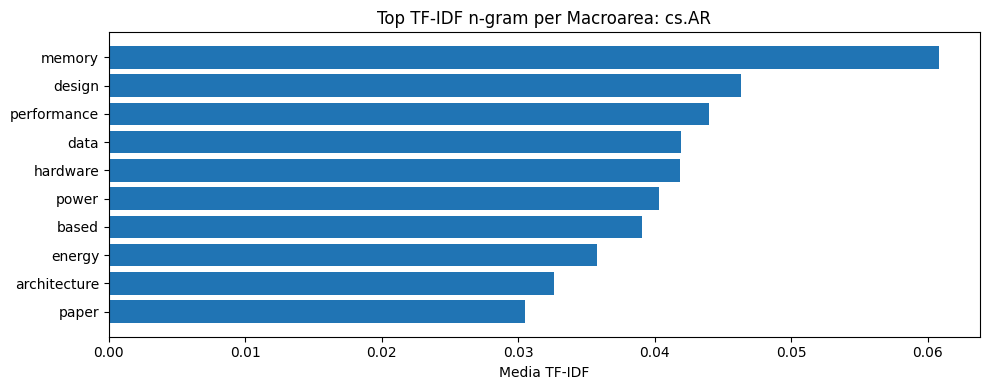

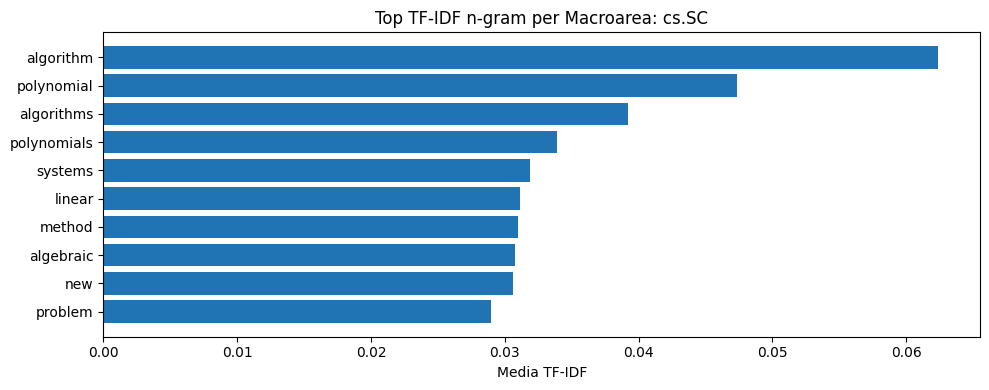

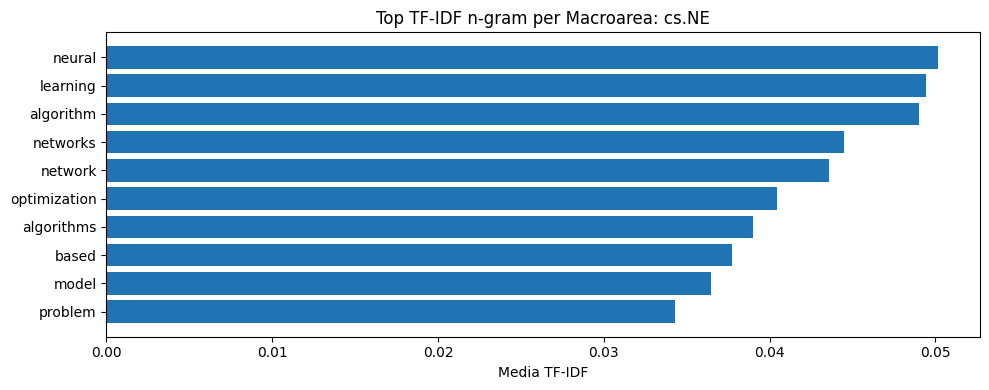

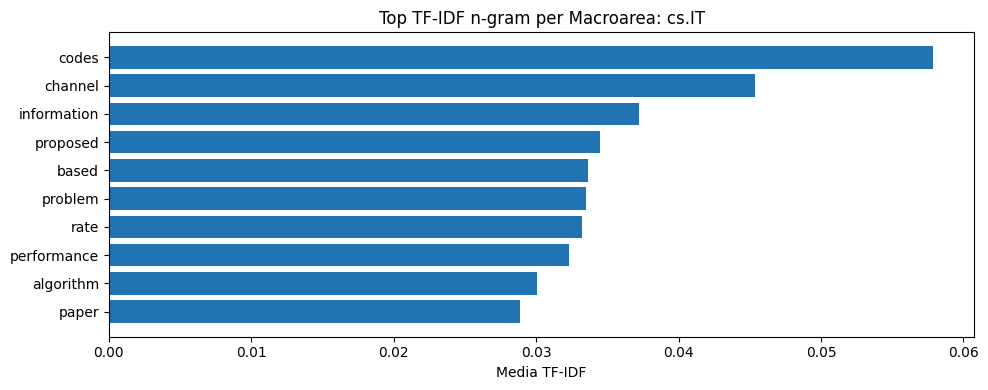

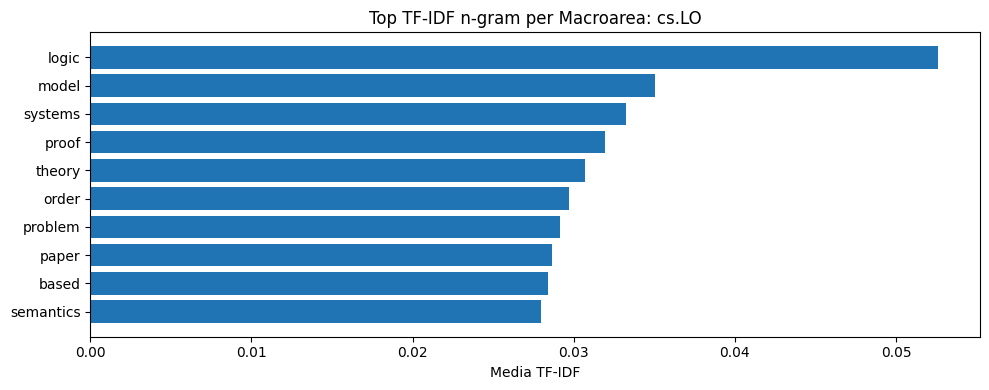

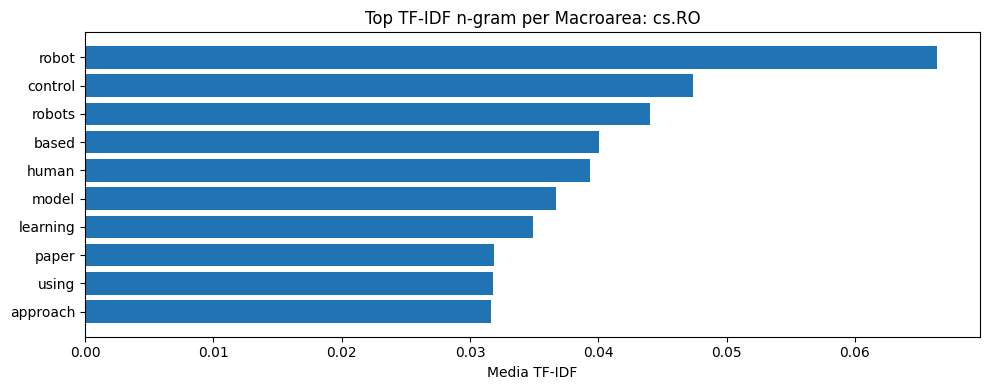

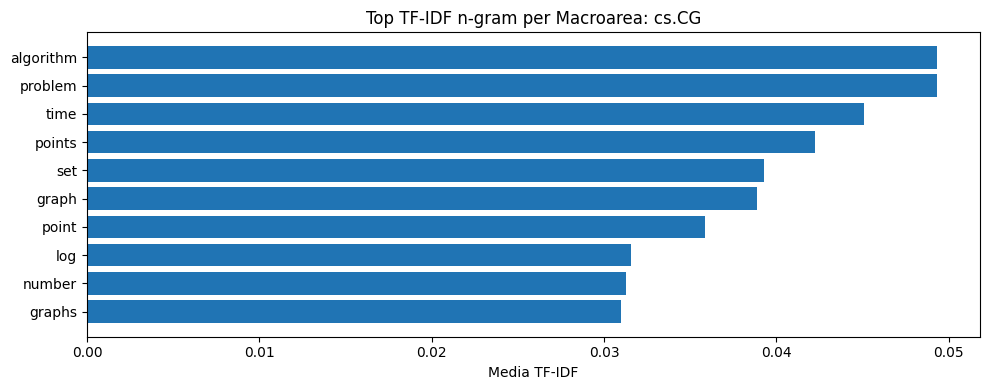

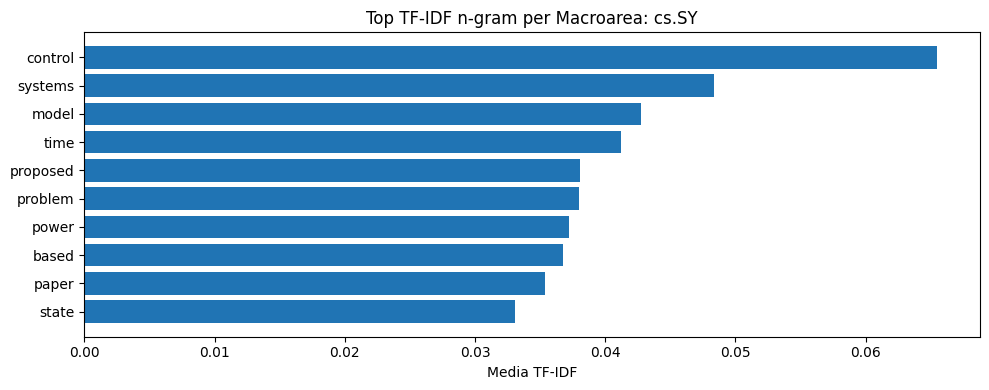

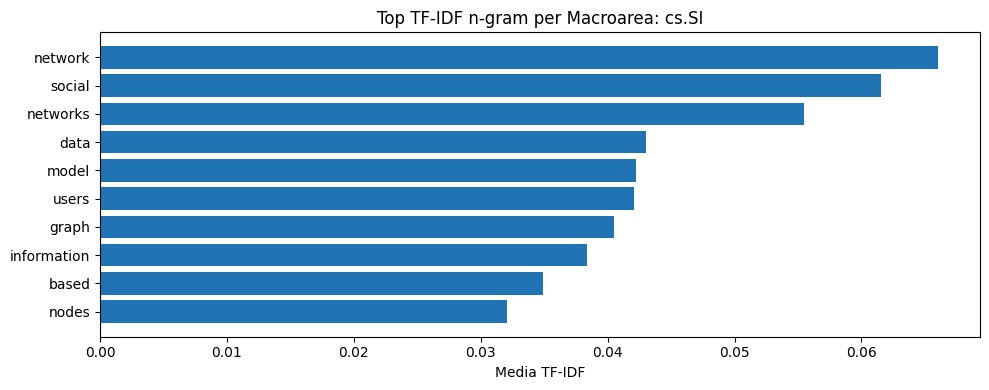

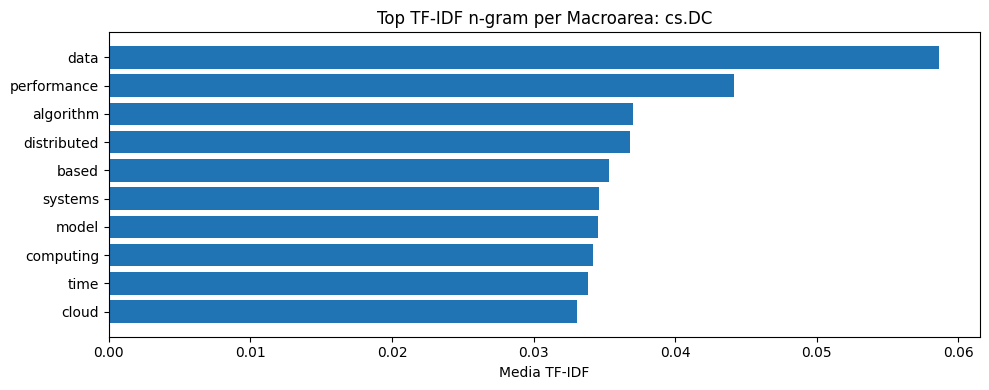

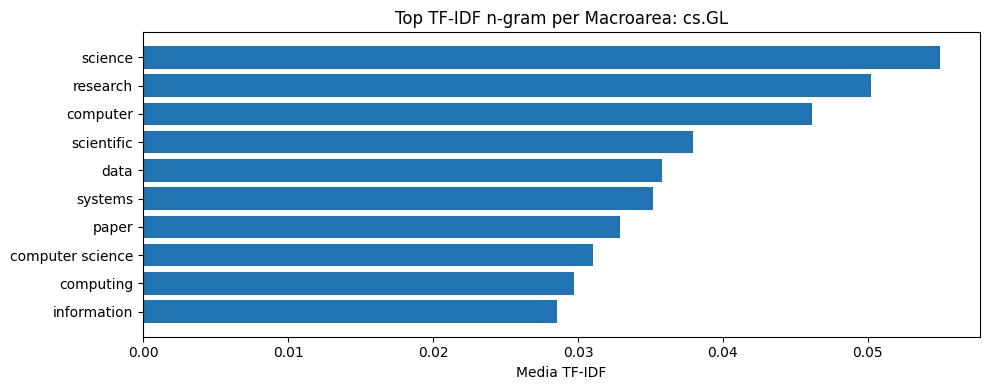

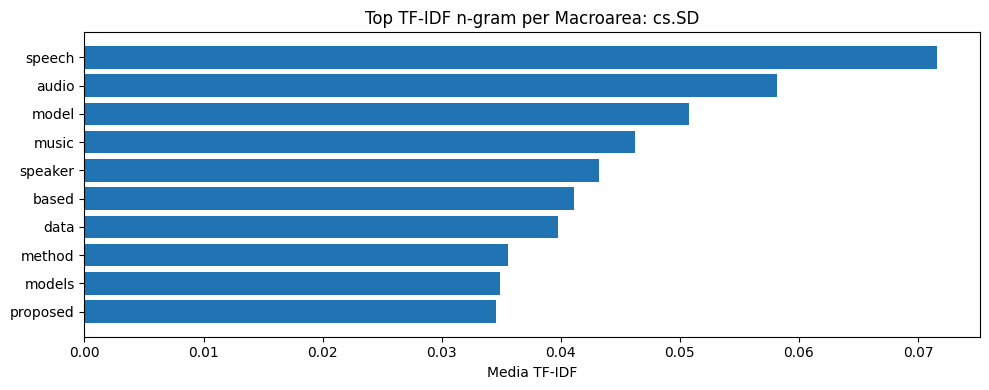

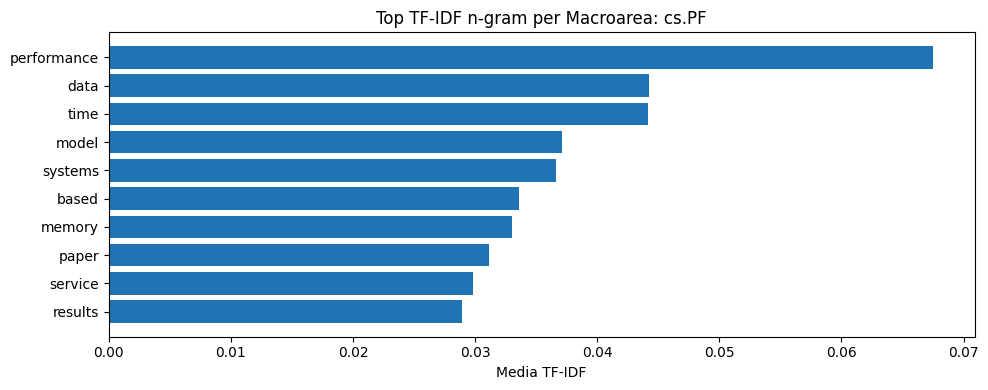

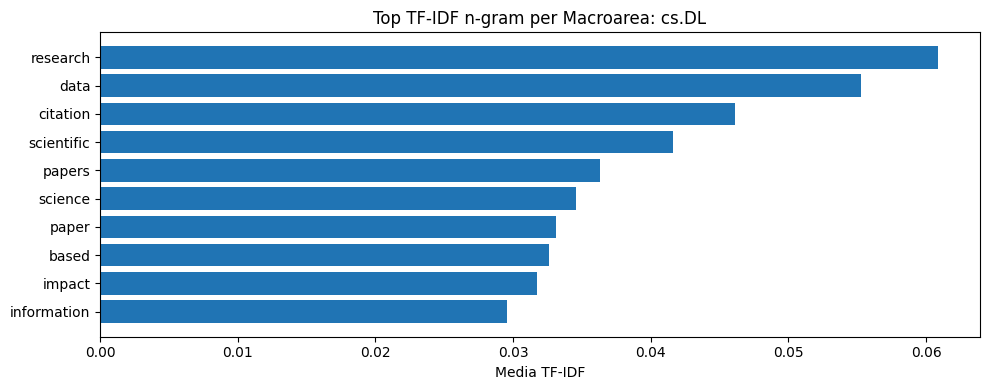

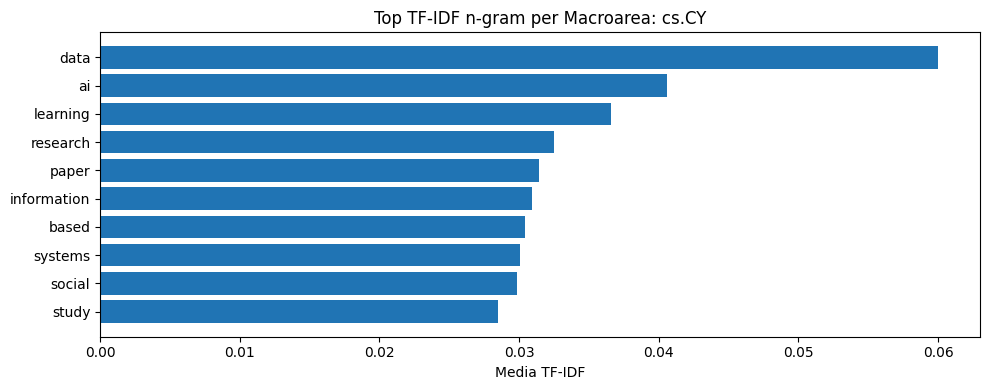

In [13]:
abstracts = df["abstract"]
labels = df["primary_category"]

macroareas = list(set(labels))

for area in macroareas:
    subset = [a for a, l in zip(abstracts, labels) if l == area]
    vectorizer = TfidfVectorizer(ngram_range=(1,3), max_features=500, stop_words='english')
    tfidf = vectorizer.fit_transform(subset)
    
    scores = tfidf.mean(axis=0).A1
    terms = vectorizer.get_feature_names_out()
    top_n = sorted(zip(terms, scores), key=lambda x: x[1], reverse=True)[:10]

    # Barplot
    terms, values = zip(*top_n)
    plt.figure(figsize=(10,4))
    plt.barh(terms, values, color= "#2074b4")
    plt.gca().invert_yaxis()
    plt.title(f"Top TF-IDF n-gram per Macroarea: {area}")
    plt.xlabel("Media TF-IDF")
    plt.tight_layout()
    plt.show()
